# Load modules

In [1]:
import functools
import time
from pprint import pprint
import shutil

import pandas as pd
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.loggers import CSVLogger

from iterativenn.lit_modules.IteratedModel import IteratedModel, ConfigCallbacks
from iterativenn.utils.model_wrappers import IterativeRNN, IterativeGRU, IterativeLSTM
from iterativenn.nn_modules.Sequential2D import Sequential2D
from iterativenn.nn_modules.Sequential1D import Sequential1D
from iterativenn.nn_modules.HeterogeneousActivation import HeterogeneousActivation

from iterativenn.utils.DatasetUtils import MemoryCopySequence
from iterativenn.utils.DataModules import SequenceModule


torch.manual_seed(0)

# Introduction


This is a example of doing time series analysis comparing INNs to other methods.  This is intended to be a simple example of how to do this.  It is not intended to be a comprehensive analysis of the methods.   However, it does show that INNs can be used for time series analysis and how to use them for this purpose.    


# The Data



We want a simple yet non-trivial problem for demonstrating the methods, so we do a memory problem.  The data is a sequence of random numbers, and the method is asked to memorize them and then repeat them back.

There are three small twists.

1.  You can make the sequences both as long as you like and have variables lengths.
2.  On the input side you can allow each digit to appear multiple times to allow for more time to memorize the sequence.
3.  You can make the dimensions of the sequences as large as you like.  I.e., the method would need to memorize vectors. 

In [2]:
globals = {}
# The number of elements in each vector to memorize
globals['dimension'] = 2
# The shortest and longest sequences to memorize
globals['min_sequence_size'] = 2
globals['max_sequence_size'] = 4
# The number of copies of each element in the sequence, i.e. the number of times each element is repeated.
globals['copies'] = 2

# The data sizes to use for training and validation
globals['train_size'] = 1024
globals['val_size'] = 1024
globals['test_size'] = 1024
globals['batch_size'] = 1024

# The number of epochs to train for
globals['max_epochs'] = 5  # Far too few for real training, but just to get things going
# globals['max_epochs'] = 1000  # A more reasonable number of epochs


In [3]:
# We set the manual seed to 0, so that the same sequence is generated each time.
# Note, this is useful for debugging and learning the code, but you should remove this line when you are ready to train your model.
torch.manual_seed(0)

In [4]:
# Create the dataset
dataset_factory = functools.partial(MemoryCopySequence, 
                                    min_sequence_size=globals['min_sequence_size'], 
                                    max_sequence_size=globals['max_sequence_size'], 
                                    dimension=globals['dimension'], 
                                    copies=globals['copies'])

Heere is some sample data.  

In [5]:
sample_dataset = dataset_factory()

Here is the first example of the data.  Note,

1.  We plotting the transpose of the data, just to make it easier to see.
2.  The sequence is of length 4.
3.  Each vector is shown twice.
4.  -1 is used to indicate the end of the sequence.
5.  nan is used to make where the loss is not evaluated.

In [6]:
print('the x values')
print(sample_dataset[0]['x'].T)
print('the y values')
print(sample_dataset[0]['y'].T)

the x values
tensor([[ 1.,  1.,  7.,  7.,  7.,  7.,  2.,  2., -1., -1., -1., -1.],
        [ 3.,  3.,  8.,  8.,  8.,  8.,  2.,  2., -1., -1., -1., -1.]])
the y values
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, 1., 7., 7., 2.],
        [nan, nan, nan, nan, nan, nan, nan, nan, 3., 8., 8., 2.]])


Here is the second example of the data.  Note,

1.  Now, the sequence is of length 2.
2.  Everything else is the same.

In [7]:
print('the x values')
print(sample_dataset[1]['x'].T)
print('the y values')
print(sample_dataset[1]['y'].T)

the x values
tensor([[ 9.,  9.,  7.,  7., -1., -1.],
        [ 3.,  3.,  4.,  4., -1., -1.]])
the y values
tensor([[nan, nan, nan, nan, 9., 7.],
        [nan, nan, nan, nan, 3., 4.]])


And we wrap the data is a pytorch lightning data module.   This is not necessary, but it makes it easier to use the data in the training loop.

In [8]:
data_module = SequenceModule(dataset=dataset_factory, 
                             batch_size=globals['batch_size'], 
                             train_size=globals['train_size'], 
                             val_size=globals['val_size'], 
                             test_size=globals['test_size'], 
                             num_workers=1)

# Construct the models

We are going to construct models in a somewhat generic fashion.  The idea is that each model takes as input a vector $z$ where $z$ consists of three parts (in order):

1. The input sequence (what we call $x$).
2. The output sequence (what we call $y$).
3. The hidden state (what we call $h$).

i.e.
$$\begin{bmatrix} x \\ y \\ h \end{bmatrix} = z$$

Why the strange order of having the hidden state at the end?  Wouldn't having $y$ at the end be more natural?  

Actually, in our work we like to play games with the size of $h$, while $x$ and $y$ are fixed by the problem of interest.  So, having  $x$ and $y$ first and $h$ last allows us to be more consistent later on.



$z$ will be processed by various callbacks.  The callbacks are:

- loss:  This is the loss function.  It takes $y$ and returns a loss.
  e.g., $$loss\left(\begin{bmatrix} x \\ y \\ h \end{bmatrix}\right) = loss(y)$$
- initialization: It initializes $z$.
  e.g., $$initialization\left(\begin{bmatrix} x \\ y \\ h \end{bmatrix}\right) = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$$
- data: It overwrites $z$ with the input data.
  e.g., $$data\left(\begin{bmatrix} x \\ y \\ h \end{bmatrix},x_{new} \right) = \begin{bmatrix} x_{new} \\ y \\ h \end{bmatrix}$$ 
- output: It prints the contents of $z$ in a human readable form.
  e.g., $$output\left(\begin{bmatrix} x \\ y \\ h \end{bmatrix}\right) = y$$

Note, $loss$, $data$, and $output$ can be defined without reference to the size of $h$.  This is because $h$ is the last part of $z$ and so can be ignored.  However, $initialization$ does need to know the size of $h$.

Note, you do not call these directly, internally they are called by the model.

In [9]:

def get_callbacks(x_size, y_size, h_size):
    loss_dict = { 'func': 'MSELoss', 'idx_list': range(x_size, x_size+y_size), 'sequence_position': 'all'}
    initialization_dict = { 'func': 'zeros', 'size': x_size+y_size+h_size}
    data_dict = { 'func': 'insert', 'idx_list': range(0, x_size), 'flatten_input': True}
    output_dict = { 'func': 'all_series', 'idx_list': range(x_size, x_size+y_size)}
    callback_dict = {'loss': loss_dict, 'initialization': initialization_dict, 'data': data_dict, 'output': output_dict}
    return ConfigCallbacks(callback_dict)

Here are a selection of standard models one can call.  Note, these are wrapped in a class so that the calling signature is consistent with our notation.  However, the internal functions are not modified in any way.

In [10]:
def RNN(x_size, y_size, h_size):
    callbacks = get_callbacks(x_size, y_size, h_size)
    model = IterativeRNN(input_size=x_size,
                         hidden_size=y_size+h_size)
    iteratedModel = IteratedModel(model=model, callbacks=callbacks, batch_optimize=True)
    return iteratedModel

def GRU(x_size, y_size, h_size):
    callbacks = get_callbacks(x_size, y_size, h_size)
    model = IterativeGRU(input_size=x_size,
                         hidden_size=y_size+h_size)
    iteratedModel = IteratedModel(model=model, callbacks=callbacks, batch_optimize=True)
    return iteratedModel

def LSTM(x_size, y_size, h_size):
    callbacks = get_callbacks(x_size, y_size, h_size)
    model = IterativeLSTM(input_size=x_size,
                          hidden_size=h_size,
                          output_size=y_size,
                          y_before_h=True)
    iteratedModel = IteratedModel(model=model, callbacks=callbacks, batch_optimize=True)
    return iteratedModel

Ok, now things get more interesting.  We now use an INN to do the same task.  This is very similar to what happens in a normal RNN, except we have finer control over the initialization, activations functions, and training.  In particular,
this can we written as

$$
f(z) =
\begin{bmatrix} I & I & ELU \end{bmatrix} 
\circ
\left(
\begin{bmatrix} x & y & h \end{bmatrix} 
\begin{bmatrix}
I & W_{xy} & W_{xh} \\
0 & W_{yy} & W_{yh} \\
0 & W_{hy} & W_{hh} \\
\end{bmatrix}
\right)
$$

where $I$ is the identity matrix/map (i.e., a function that just copies the input to the output) and $\circ$ is entry-wise function composition.  Note, we are writing this in terms of row vectors and left dot products to be consistent with the standard Pytorch notation.

We can expand this by writing 
$$
f(z) =
\begin{bmatrix} I & I & ELU \end{bmatrix} 
\circ
\begin{bmatrix} x & x W_{xy} + y W_{yy} + h W_{hy} &  x W_{xh} + y W_{yh} + h W_{hh}\end{bmatrix} 
$$

and apply the activation function to each column to get

$$
f(z) =
\begin{bmatrix} x & x W_{xy} + y W_{yy} + h W_{hy} &  ELU(x W_{xh} + y W_{yh} + h W_{hh})\end{bmatrix} 
$$

and this is one iteration of our INN/RNN/dynamical system.

In [11]:
def DenseINN(x_size, y_size, h_size):
    default_model = 'MaskedLinear.from_description'
    default_kwargs = {'block_type':'W', 'initialization_type':'G=0.0,0.01', 'trainable':True, 'bias':False}

    cfg = {
            "in_features_list": [x_size, y_size, h_size], 
            "out_features_list": [x_size, y_size, h_size], 
            "block_types": [
                    ['Identity', default_model, default_model],
                    [None,       default_model, default_model],
                    [None,       default_model, default_model]
                ],
            "block_kwargs": [
                    [None, default_kwargs, default_kwargs],
                    [None, default_kwargs, default_kwargs],
                    [None, default_kwargs, default_kwargs]
                ],
        }

    # We use the above config to create a Sequential2D model.  Note, this can also be done by hand, and not using the config factory.
    # However, this is a bit cleaner and easier to get started with.
    base_model = Sequential2D.from_config(cfg)

    # There are our chosen activations for each layer.  Note, you can choose these as you like based upon your problem.
    # for example, you might want to make the activations for $y$ something like a sigmoid if you are doing classification.
    base_activations = [torch.nn.Identity(), torch.nn.Identity(), torch.nn.ELU()]
    activation = HeterogeneousActivation(base_activations, [x_size, y_size, h_size])


    # We create a Sequential1D which applied the activations to the output of the Sequential2D model.
    model = Sequential1D(base_model, activation, 
                        in_features=base_model.in_features, 
                        out_features=base_model.out_features)

    # There are a few callbacks we need to use to make this work as described above.
    callbacks = get_callbacks(x_size, y_size, h_size)

    # Note, the batch_optimize=True collects a batch of training sequences and sends them to the model at once.  It should
    # be faster for large models.  
    iteratedModel = IteratedModel(model=model, callbacks=callbacks, batch_optimize=True)
    return iteratedModel

Ok, now we can do something interesting!  This is now a sparse RNN/INN/dynamical system where only the non-zero entries of the $W$ matrices are trainable.  This is a very powerful idea.
It allows us to do things like:

- simulate a dynamical system with a small number of parameters.
- simulate an MLP
- decouple the size of $h$ from the number of parameters
- etc.

In [12]:
def SparseINN(x_size, y_size, h_size):
    default_model = 'MaskedLinear.from_description'
    default_kwargs = {'block_type':'R=0.2', 'initialization_type':'G=0.0,0.01', 'trainable':'non-zero', 'bias':False}

    cfg = {
            "in_features_list": [x_size, y_size, h_size], 
            "out_features_list": [x_size, y_size, h_size], 
            "block_types": [
                    ['Identity', default_model, default_model],
                    [None,       default_model, default_model],
                    [None,       default_model, default_model]
                ],
            "block_kwargs": [
                    [None, default_kwargs, default_kwargs],
                    [None, default_kwargs, default_kwargs],
                    [None, default_kwargs, default_kwargs]
                ],
        }

    base_model = Sequential2D.from_config(cfg)
    base_activations = [torch.nn.Identity(), torch.nn.Identity(), torch.nn.ELU()]

    activation = HeterogeneousActivation(base_activations, [x_size, y_size, h_size])
    model = Sequential1D(base_model, activation, 
                        in_features=base_model.in_features, 
                        out_features=base_model.out_features)
    callbacks = get_callbacks(x_size, y_size, h_size)
    iteratedModel = IteratedModel(model=model, callbacks=callbacks, batch_optimize=True)
    return iteratedModel

Now we go for it!  This is an example with some untrainable blocks, and trainable blocks with variable sparsity.  This sky is the limit!
For example one can consider:

- different activation functions
- learning an optimal configuration of trainable parameters
- using biases as well as weights
- studying the dynamics of the system
- etc.

In [13]:
def VariableINN(x_size, y_size, h_size):
    default_model = 'MaskedLinear.from_description'
    default1_kwargs = {'block_type':'R=0.1', 'initialization_type':'G=0.0,0.01', 'trainable':'non-zero', 'bias':False}
    default2_kwargs = {'block_type':'R=0.2', 'initialization_type':'G=0.0,0.01', 'trainable':'non-zero', 'bias':True}

    cfg = {
            "in_features_list": [x_size, y_size, h_size//2, h_size//2], 
            "out_features_list": [x_size, y_size, h_size//2, h_size//2], 
            "block_types": [
                    ['Identity', default_model, default_model, None         ],
                    [None,       default_model, None,          default_model],
                    [None,       None         , default_model, default_model],
                    [None,       default_model, default_model, None         ],
                ],
            "block_kwargs": [
                    [None,       default1_kwargs, default2_kwargs, None          ],
                    [None,       default2_kwargs, None,            default2_kwargs],
                    [None,       None,            default1_kwargs, default1_kwargs],
                    [None,       default1_kwargs, default2_kwargs, None          ],
                ],
        }

    base_model = Sequential2D.from_config(cfg)
    base_activations = [torch.nn.Identity(), torch.nn.Identity(), torch.nn.ELU(), torch.nn.Tanh()]

    activation = HeterogeneousActivation(base_activations, [x_size, y_size, h_size//2, h_size//2])
    model = Sequential1D(base_model, activation, 
                        in_features=base_model.in_features, 
                        out_features=base_model.out_features)

    # Note, in this case the sizes of the callbacks are different than the sizes of the model!  This is perfectly fine.
    callbacks = get_callbacks(x_size, y_size, h_size)
    iteratedModel = IteratedModel(model=model, callbacks=callbacks, batch_optimize=True)
    return iteratedModel

In [14]:
models = {
    'RNN': RNN(x_size=globals['dimension'], y_size=globals['dimension'], h_size=100),
    'GRU': GRU(x_size=globals['dimension'], y_size=globals['dimension'], h_size=55),
    'LSTM': LSTM(x_size=globals['dimension'], y_size=globals['dimension'], h_size=400),
    'DenseINN': DenseINN(x_size=globals['dimension'], y_size=globals['dimension'], h_size=100),
    'SparseINN': SparseINN(x_size=globals['dimension'], y_size=globals['dimension'], h_size=230),
    'VariableINN': VariableINN(x_size=globals['dimension'], y_size=globals['dimension'], h_size=310),
}

In [15]:
for model_name, model in models.items():
    print(f'{model_name} has {model.number_of_trainable_parameters()} trainable parameters')


RNN has 10812 trainable parameters
GRU has 10431 trainable parameters
LSTM has 10400 trainable parameters
DenseINN has 10608 trainable parameters
SparseINN has 10944 trainable parameters
VariableINN has 10137 trainable parameters


In [16]:
shutil.rmtree('logs/1-rcp-time-series', ignore_errors=True)
for model_name, model in models.items():
    
    logger = CSVLogger("logs/1-rcp-time-series", name=model_name)

    trainer=pl.Trainer(logger=logger, enable_checkpointing=False, 
                       devices=1 if torch.cuda.is_available() else None,
                       accelerator='auto',
                       max_epochs=globals['max_epochs'], callbacks=[RichProgressBar()])
    start_time = time.perf_counter()
    trainer.fit(model, data_module)
    print(f"Time elapsed: {time.perf_counter() - start_time} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ IterativeRNN │ 10.8 K │
└───┴───────┴──────────────┴────────┘

Trainable params: 10.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_
connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_
connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: 
PossibleUserWarning: The number of training batches (1) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=5` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Time elapsed: 10.468435139977373 seconds


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ IterativeGRU │ 10.4 K │
└───┴───────┴──────────────┴────────┘

Trainable params: 10.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=5` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Time elapsed: 9.696498972014524 seconds


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ IterativeLSTM │ 10.4 K │
└───┴───────┴───────────────┴────────┘

Trainable params: 10.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=5` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Time elapsed: 10.01786127104424 seconds


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ Sequential1D │ 31.8 K │
└───┴───────┴──────────────┴────────┘

Trainable params: 10.6 K                                                                                           
Non-trainable params: 21.2 K                                                                                       
Total params: 31.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=5` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Time elapsed: 9.66851232200861 seconds


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ Sequential1D │  162 K │
└───┴───────┴──────────────┴────────┘

Trainable params: 54.3 K                                                                                           
Non-trainable params: 108 K                                                                                        
Total params: 162 K                                                                                                
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=5` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Time elapsed: 10.041671909042634 seconds


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ Sequential1D │  219 K │
└───┴───────┴──────────────┴────────┘

Trainable params: 73.5 K                                                                                           
Non-trainable params: 146 K                                                                                        
Total params: 219 K                                                                                                
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=5` reached.


Time elapsed: 10.18228639906738 seconds


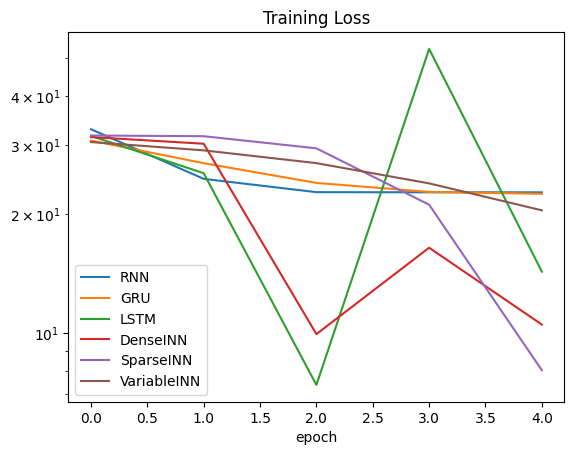

In [17]:
plt.title('Training Loss')
for model_name, model in models.items():
    metrics = pd.read_csv(f'logs/1-rcp-time-series/{model_name}/version_0/metrics.csv')
    valid_idx = ~metrics['training_loss'].isna()
    metrics = metrics[valid_idx]
    metrics.plot(x='epoch', y='training_loss', ax=plt.gca(), label=model_name, logy=True)

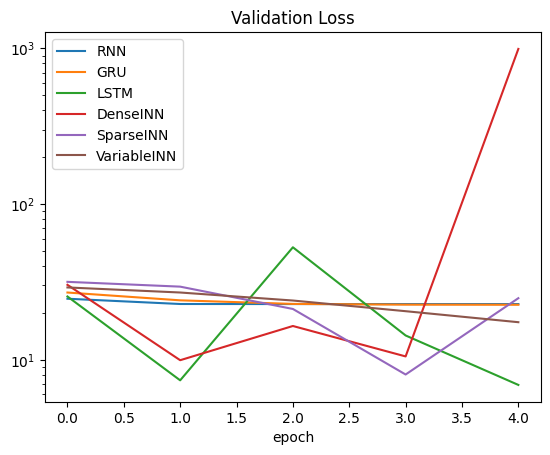

In [18]:
plt.title('Validation Loss')
for model_name, model in models.items():
    metrics = pd.read_csv(f'logs/1-rcp-time-series/{model_name}/version_0/metrics.csv')
    valid_idx = ~metrics['validation_loss'].isna()
    metrics = metrics[valid_idx]
    metrics.plot(x='epoch', y='validation_loss', ax=plt.gca(), label=model_name, logy=True)